# Machine Learning (ML) Classification

The most common supervised learning tasks
1. *regression* (predicting values) and
2. *classification* (predicting classes).

This notebook focuses on building classification models that operates on the MNIST dataset. The MNIST dataset consists of handwritten Arabic numerals (i.e. the digits $0$, $1$, $2$, $3$, $4$, $5$, $6$, $7$, $8$, and $9$). To learn the basics, we will initially build a *binary* classifier that decides whether or not an instance represents a $5$. Once we gain some initial understanding, we will train a classifier to decide which digit an instance most likely represents.

As with most data-based Python notebooks, we begin with a preamble of the most essential modules for machine learning and data science and our plotting preamble.

In [1]:
import sys
assert sys.version_info >= (3, 7)
import sklearn
assert sklearn.__version__ >= "1.0.1"
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pathlib import Path
plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('mathtext', fontset='dejavuserif')

Generating images tells the story of our exploration, so saving them is essential. To avoid repetition, we initially write a workhorse function to save our figures.

In [46]:
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## The MNIST Dataset
The MNIST (Modified National Institute of Standards and Technology) dataset (sometimes referred to as the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database)) is a set of $70\mathrm{k}$ small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the "hello world" of machine learning. Whenever a new classification algorithm is engineered, applying it to the MNIST dataset is generally one of the first measures of its effectiveness.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
mnist.keys()

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including
- a `DESCR` key describing the dataset
- A `data` key containing an array with one row per instance and one column per feature
- A `target` key containing an array with the labels
Let's look at these arrays.

In [3]:
X, y = mnist['data'], mnist['target']
print(f'X shape:{X.shape}\ny shape:{y.shape}')

X:(70000, 784)
y:(70000,)


To review, rows and columns in a dataset are referred to as *instances* and *features* in machine learning. In the MNIST dataset, there are $70\mathrm{k}$ instances representing images, and each image has $784$ features because each image is $28\times28$ pixels (note that $28^2=784$).

For each image, each feature represents a single pixel's intensity from $0$ (white) to $255$ (black). Translating a single instance of this numerical data into actual images is the first thing we're going to do. We'll accomplish this by selecting an instance's feature vector (i.e. selecting a row of data), reshaping it to a $28\times28$ Numpy array, and then displaying it using Matplotlib's `pyplot.imshow()` function.

In [52]:
def plot_digit(image_data:pd.Series, plot_name:str='some-digit', save:bool=False):
    image = image_data.values.reshape(28,28) # Reshape the Series values into a 28x28 array (think of it as a matrix from linear algebra).
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    if save:
        save_fig(plot_name)

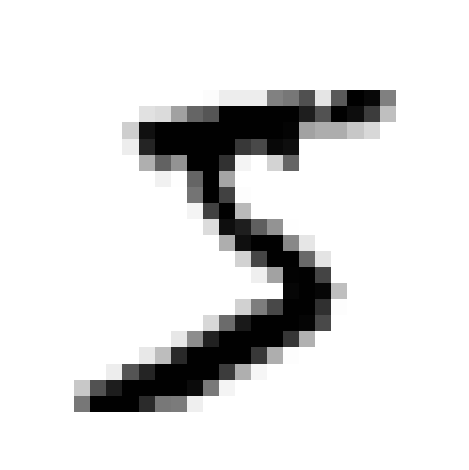

In [53]:
some_digit = X.iloc[0] # Grab the first row of data in the DataFrame (at index 0). This returns as a pandas Series.
plot_digit(some_digit, plot_name='first-digit', save=True)

This looks like a $5$, and indeed that's what the label tells us. We will use `some_digit` throughout this notebook, so it's important to remember that it represents a $5$.

In [5]:
y.iloc[0]

'5'

Note that the label is a *string*. Most ML algorithms expect numbers, so let's cast `y` as an integer.

In [54]:
y = y.astype(np.uint8)

To get a feel for the complexity of the classification task before us, let's generate a $10\times10$ grid of images from the MNIST dataset.

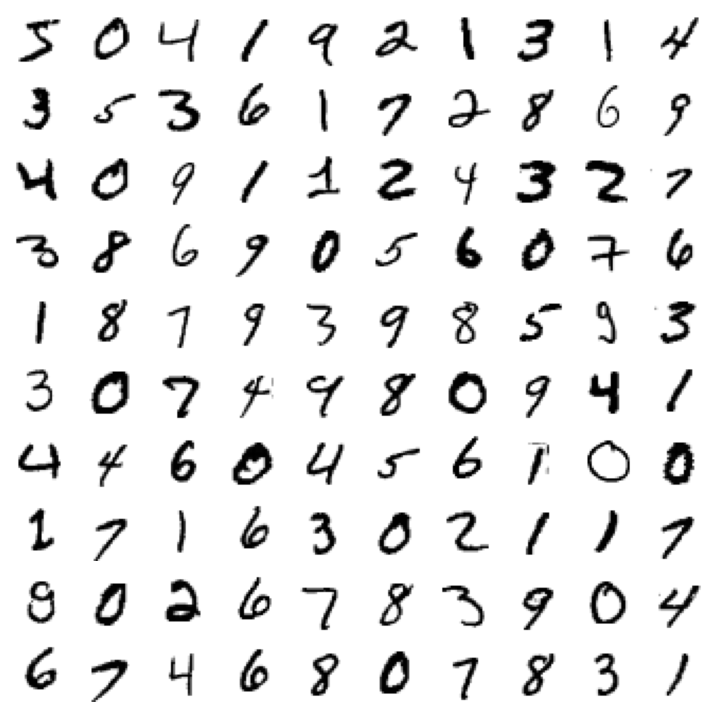

In [57]:
plt.figure(figsize=(9, 9))
for i, image_data in X.iterrows():
    if i==100:
        break
    plt.subplot(10, 10, i + 1) # Iterate through the 10x10 grid, plotting a digit at each index.
    plot_digit(image_data)
save_fig('100-digits', tight_layout=False)
plt.show()

## Relative Distribution of Digits
Before we begin, let's see the relative distribution of digits. Intuitively, we may suspect that if these digits were sourced from pages dealing with phone numbers or addresses, each digit should around the same frequency of occurrence in the dataset, meaning that each one shows up about $10\%$ of the time.

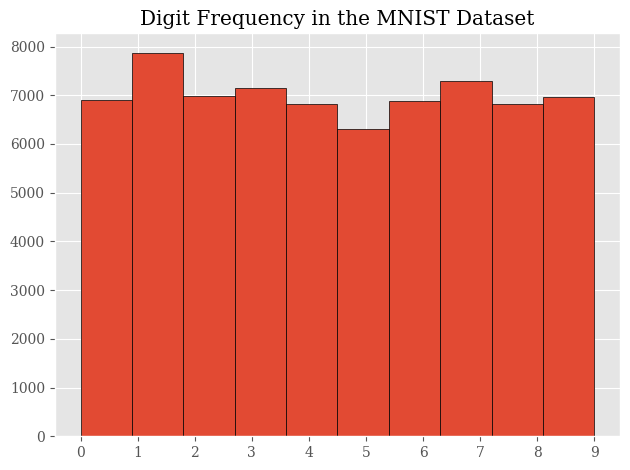

In [70]:
plt.figure()
ax = y.hist(ec='black')
ax.set_xticks(list(range(0,10)))
ax.set_title('Digit Frequency in the MNIST Dataset')
save_fig('digit-frequency')
plt.show()

## The Train/Test Split
**In ML, we should *always* create a test set and set it aside before inspecting the data closely.** The MNIST dataset is actually already split into a training set (the first $60\mathrm{k}$ images) and a test set (the last $10\mathrm{k}$ images).

In [71]:
cut_idx = 60000
X_train, X_test, y_train, y_test = X[:cut_idx], X[cut_idx:], y[:cut_idx], y[cut_idx:]

The training set is already appropriately shuffled for us. If it wasn't, we'd have to use [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) during our shuffling to ensure all cross-validation folds contain a representative sample of each digit. Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Appropriately shuffling the dataset before the train/test split decreases the risk of poor predictive performance*.

*Time series data is a notable exception to this rule.

## Training a Binary Classifier
We'll begin by building a classifier that attempts to detect whether a digit represents $5$ or $\neg5$ ($\neg$ is the logical negation operator). Since the classifier only has two options for its predictions, its known as a *binary classifier*. Let's create the *target vectors* for this classification task. For binary classifiers, target vectors are boolean arrays.

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

We must now pick a classification model and train it. A good place to start is with a *Stochastic Gradient Descent* (SGD) classifer, and we can employ Scikit-Learn's `SGDClassifier` class. This classifier operates efficiently for *very large datasets*. Part of this efficiency resides in the fact that SGD trains instances independently, one at a time (which also makes SGD well-suited for [*online learning*](https://en.wikipedia.org/wiki/Online_machine_learning)). Let's create an `SGDClassifier` and train it on the training set (*not* the entire dataset!). It's vitally important leave the test set untouched until model training is complete.

In [72]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train.values, y_train_5.values)

SGDClassifier(random_state=42)

We're now able to employ our trained classifier to detect images of the of the number $5$.

In [11]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this images represents a $5$. Since we checked `some_digit` manually, we know this to be a correct prediction. Our next step is to evaluate our model's performance.

## Performance Measures
Based on how most people interpret what error in a model means, evaluating error in a classifier is often significantly trickier to explain than evaluating error in a regressor. Just like regressors, there are many performance measures available.

## Measuring Accuracy Using Cross-Validation
A reliable way to evaluate a model is to use cross-validation. This applies to both regressors and classifiers.

## Implementing Cross-Validation
Occasionally, we will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, we can implement the cross-validation ourselves. The following code does roughly the same thing as Scikit-Learn's `cross_val_score()` function, and it prints nearly identical results.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred), end=' ')

0.9669 0.91625 0.96785 

The `StratifiedKFold` class performs stratified sampling to produce folds that contain a representative ratio of each class (about 10% each in this case). At each iteration, the code creates a clone of the classifier, trains that clone on the *training* folds, and then makes predictions on the *test* fold. Lastly, it counts the number of correct predictions and outputs the ratio of correct predictions.

Let's use the `cross_val_score()` function to evaluate our `SGDClassifier` model and employ K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the $\left(\mathrm{K}-1\right)$ other folds.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Achieving above a $93\%$ accuracy for the ratio of correct predictions on all cross-validated folds seems compelling, but this performance metric is actually a red herring. This can be demonstrated by examining how a poorly-implemented classifier performs under `cross_val_score()`. Specifically, let's look at one that classifies every single image as $\neg5$

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Why do we have over $90\%$ accuracy with this admittedly horribly-designed model? Recall that only about $10\%$ of the images represent a $5$, so if we always guess than an image is $\neg5$, we'll be right about $90\%$ of the time. This concept demonstrates why **accuracy is generally *not* the preferred performance measure for classifiers**, especially when dealing with *skewed datasets*. A skewed dataset is one wherein some classes are much more frequent than others.

## The Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at its confusion matrix. For a binary classifier, the general idea is to count the number of times instances of class $\mathrm{A}$ are classified as class $\mathrm{B}$. If we were to create a classifier that accounted for all digit types, to know the number of times the classifier confused images representing a $5$ with $3$, we would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, we need a set of predictions to compare to the target vectors. We *could* make predictions on the test set, but doing so is bad practice. Touching the test set introduces bias. To reiterate, we *only* want to use the test set at the *very end* of our project, once our classifier is trained and potentially ready to launch. Rather than using the test set, we can employ Scikit-Learn's `cross_val_predict()` function.

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, **it returns the predictions made on each test fold**. This means we get a clean prediction for each instance in the training set. Here, "clean" means the prediction is made by a model that never saw the data during training.

Armed with cross-validated predictions, we can now compute the confusion matrix for our classifier using the `confusion_matrix()` function by passing it the target classes (`y_train_5`) and the predicted classes (`y_train_pred`).

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

How should we interpret this? Each row in a confusion matrix represents represents an *actual* class, while each column represents a *predicted* class.

|         | $\neg5$ |   $5$   |
|---------|---------|---------|
| $\neg5$ |    TN   |   FP    |
|   $5$   |    FN   |   TP    |

**Row 1**

The first row of this matrix considers $\neg5$ images (the *negative* class). In the above instance, roughly $53\mathrm{k}$ of the images were correctly classified as $\neg5$, so we call these *true negatives*. The remaining $687$ were wrongly classified as $5$ (*false positives*).

**Row 2**

In the second row considers the images representing $5$ (the *positive* class). $1891$ were wrongly classified as $\neg5$ (*false negatives*) while the remaining $3530$ were correctly classified as $5$ (*true positives*).

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right).

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall

The confusion matrix gives us a lot of information, but sometimes we may prefer a concise metric. One option is to the look at the accuracy of positive predictions, or the number of correct positive classifications among all positive classifications. This is called the *precision* of a classifier.

$$\mathrm{precision}=\frac{TP}{TP+FP}$$

$TP$ is the number of true positives and $FP$ is the number of false positives.

A trivial way to attain perfect precision is to make one single positive prediction and ensure it is correct. To balance out this possibility, precision is usually employed alongside another metric called *recall* (aka *sensitivity* or the *true positive rate* $\left(TPR\right)$). Recall is the ratio of positive instances that are correctly detected by the classifier and the actual number of positive instances.

$$\mathrm{recall}=\frac{TP}{TP+FN}=\mathrm{sensitivity}=TPR$$

**Note the subtle difference here.** Precision is weighted by the number of positives predicted by the classifier, and $FP$ can vary over a considerable range. Recall is weighted by the number of actual positive instances in the data, which is *fixed*.

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall

In [18]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print(f'precision: {precision:.2f}\nrecall: {recall:.2f}')


precision: 0.84
recall: 0.65


Before, we had an *accuracy* above $90\%$, but suddenly our $5$-detector doesn't look as shiny. From these metrics, we can say
1. When the classifier claims an image represents a $5$, it is correct only $84\%$ of the time.
2. The classifier only detects $65\%$ of the digits representing $5$.

**It is often convenient to combine precision and recall into a single metric called the $F_1$ score**. The $F_1$ score is particularly useful as a simple tool to compare two classifiers. The $F_1$ score is the *harmonic mean* of precision and recall.

$$F_1=\frac{2}{\frac{1}{\mathrm{precision}}+\frac{1}{\mathrm{recall}}}=2\cdot\frac{\mathrm{precision}\cdot\mathrm{recall}}{\mathrm{precision}+\mathrm{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

Unlike the arithmetic mean which weights all values equally, the harmonic mean gives much more weight to small values. With this type of weighting, a classifier will only achieve a relatively high $F_1$ score if both recall and precision are high.

In Scikit-Learn, we can compute the $F_1$ score of a classifier with the `f1_score()` function.

In [19]:
from sklearn.metrics import f1_score
f1score = f1_score(y_train_5, y_train_pred)
print(f'f1 score: {f1score:.2f}')

f1 score: 0.73


The $F_1$ score favors classifiers that have *similar* precision and recall, but this is not always desirable. In some contexts, we may want to emphasize precision while in others we may more heavily favor recall.

#### Favoring Precision: Videos for Kids
As an example, if we are training a classifier to detect videos that are safe for kids, we would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision). If this type of classifier had much higher recall but lets a few extremely inappropriate videos show up in a product geared for kids, just a few mistakes would render the product a failure. Given the severity of consequences for failures, even adding a human reviewer to the pipeline to check the classifier's video selection may be appropriate.

#### Favoring Recall: Shoplifting
In a different instance, let's consider training a classifier to detect shoplifters in surveillance images. For this case, it's probably fine if the classifier has only 30% precision as long as it has a 99% recall. Even though security reviewers will receive false alerts, nearly *all* shoplifters will be caught.

In the end though, we can't have our cake and eat it too. Increasing precision reduces recall, and vice versa. This is called the **precision/recall trade-off**.

## The Precision/Recall (PR) Trade-Off
To understand this trade-off, let's look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a *decision function*. If that score is greater than a *threshold*, it assigns the instance to the positive class, otherwise it assigns it to the negative class. Adjusting this threshold changes the values of $TP$, $FP$, $TN$, and $FN$, thus adjusting precision and recall.

Consider a situation where a larger *decision score* (calculated by the decision function) is further to the right, and we have several digits to be classified. If a digit is further to the right, it predicted more strongly to be a $5$.

$8\qquad7\qquad3\qquad9\qquad5\qquad2\qquad5\qquad5\qquad6\qquad5\qquad5\qquad5$

Let's see how precision and recall adjust as we change where the threshold is located.

$8\qquad7\qquad3\qquad9\quad|\quad5\qquad2\qquad5\qquad5\qquad6\qquad5\qquad5\qquad5$

Here, $\frac{6}{8}$ digits past the threshold are indeed $5$ ($75\%$ precision) and every $5$ in the dataset was caught ($100\%$ recall).

$8\qquad7\qquad3\qquad9\qquad5\qquad2\qquad5\quad|\quad5\qquad6\qquad5\qquad5\qquad5$

Now we see $\frac{4}{5}$ digits past the threshold are $5$ ($80\%$ precision), but only $\frac{4}{6}$ digits representing $5$ were caught ($67\%$ recall).

$8\qquad7\qquad3\qquad9\qquad5\qquad2\qquad5\qquad5\qquad6\quad|\quad5\qquad5\qquad5$

In this instance, $\frac{3}{3}$ digits past the threshold are $5$ ($100\%$ precision), but only $\frac{3}{6}$ were caught ($50\%$ recall).

From this example, we can conclude that **the higher the threshold, the lower the recall**. In practical implementation, a higher threshold also indicates higher precision (in the vast majority of cases).


Scikit-Learn does not let us set the threshold of decision functions directly, but it *does* give us access to the *decision scores* used to make predictions. Instead of calling the classifier's `predict()` method, we can call its `decision_function()` method to return a score for each instance, and then we can use any threshold we want to enable making predictions based on these scores.

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
thresholds = [0, 8000]
for threshold in thresholds:
    y_some_digit_pred = (y_scores > threshold)
    print(f'threshold of {threshold:>4}: {y_some_digit_pred}')

threshold of    0: [ True]
threshold of 8000: [False]


This example demonstrates how raising the threshold decreases the recall. We know that `some_digit` actually represents a $5$. The classifier detects the $5$ correctly when the threshold is $0$, but completely misses it when the threshold increases to $8000$.

How should we decide which threshold to use? First, let's use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time let's specify that we want to return *decision scores* rather than predictions.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

Equipped with these scores, we can use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds.

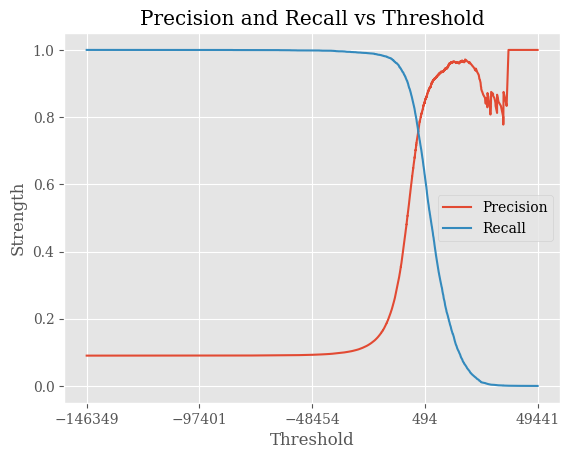

In [73]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, save=False):
    plt.plot(thresholds, precisions[:-1], label = 'Precision') #[:-1] because there are n-1 thresholds for n precisions/recalls.
    plt.plot(thresholds, recalls[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.xticks(np.linspace(thresholds[0], thresholds[-1], 5))
    plt.ylabel('Strength')
    plt.title('Precision and Recall vs Threshold')
    plt.legend()
    if save:
        plt.savefig('images/precision-vs-recall')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds, save=True)

Why is the precision curve less smooth than the recall curve? Whereas recall *only* goes down when the decision score threshold is increased, precision still retains the possibility to go up and down. Let's again consider the example sequence of numbers we used previously.

$8\qquad7\qquad3\qquad9\qquad5\qquad2\qquad5\quad|\quad5\qquad6\qquad5\qquad5\qquad5$

$(\mathrm{precision}=80\%,\ \mathrm{recall}=67\%)$

$8\qquad7\qquad3\qquad9\qquad5\qquad2\qquad5\qquad5\quad|\quad6\qquad5\qquad5\qquad5$

$(\mathrm{precision}=75\%,\ \mathrm{recall}=50\%)$

Notice that precision actually decreases! Another way to evaluate precision versus recall is to plot the two directly against each other, so let's do that.

In [103]:
(test >= 30).argmax()

9

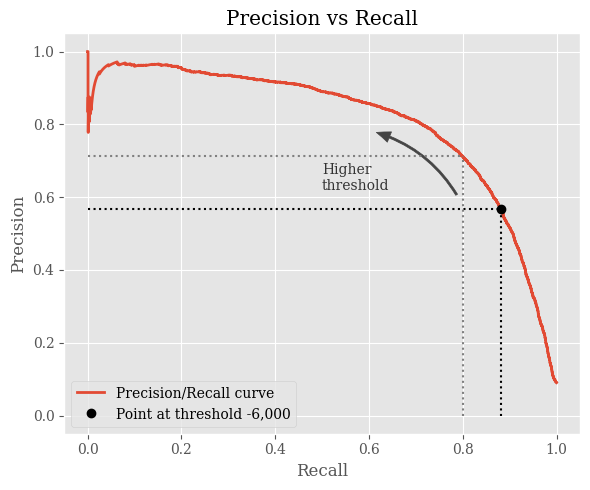

In [76]:
import matplotlib.patches as patches
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')

threshold = -6000
idx = (thresholds >= threshold).argmax()
# How does argmax work? np.argmax() returns the maximum value of a numpy array,
# but if the array has multiple occurrences of a maximum value, the index
# corresponding to the FIRST occurrence is returned. (threshold >= threshold) produces a boolean array,
# So the first instance of True is returned, or the first instance where a threshold value exceeds the 
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], 'k:')
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot([recalls[idx]], [precisions[idx]], 'ko', label=f'Point at threshold {round(thresholds[idx]):,d}')
plt.gca().add_patch(patches.FancyArrowPatch(
                    (0.79, 0.60), (0.61, 0.78),
                    connectionstyle='arc3,rad=.2',
                    arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
                    color='#444444'))
plt.text(0.50, 0.62, 'Higher\nthreshold', color='#333333')
recall_dropoff = 0.8
# precision_dropoff = precisions[find_nearest_idx(recalls, 0.8)]
precision_dropoff = precisions[(recalls < recall_dropoff).argmax()]
dropoff_kwargs = dict(color='grey', linestyles=':')
plt.vlines(x=recall_dropoff, ymin=0, ymax=precision_dropoff, **dropoff_kwargs)
plt.hlines(y=precision_dropoff, xmin=0, xmax=recall_dropoff, **dropoff_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.legend(loc='lower left')
save_fig('precision-against-recall')

plt.show()

The grey dotted line shows that precision starts to fall off sharply around $80\%$ recall. In most cases, we'll probably want to select a PR trade-off at or before this significant drop, but our specific choice will depend on other characteristics of the project (recall the applications for kids versus shoplifting we discussed previously).

If we'd like to aim for a specific precision level (say, $90\%$), we'll need to find the lowest threshold that gives us at least $90\%$ precision. How do we accomplish this? We could write a function `idx_closest_to_value()`.

In [ ]:
def idx_closest_to_value(array, value):
    array = np.array(array)
    return np.abs(array-value).argmin()

This function reads well, but the same functionality is easily accessed through Numpy's `argmin` or `argmax`. Consider a snippet from the code we used to generate the ROC curve previously.
```
threshold = -6000
idx = (thresholds >= threshold).argmax()
```

How does `argmax` work here? `argmax()` returns the maximum value of a Numpy array, but if the array has multiple occurrences of a maximum value, the index corresponding to the *first* occurrence is returned. `(threshold >= threshold)` produces a *boolean* array (e.g. `[False, False, False, ..., True, True, ...]`), so the *first* instance of `True` is returned, which ends up being the first instance where a threshold value exceeds -6000.

Instead of `idx_closest_to_value()`, we can just use `argmax` (or `argmin` in a similar manner).

In [88]:
threshold_90_precision = thresholds[(precisions >= 0.90).argmax()]
threshold_90_precision

3370.0194991439566

To make predictions (on the training set for now), instead of calling the classifier's `predict()` method, we can look at the `y_scores` above the `90%` precision threshold.

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

We can then check these predictions' precision and recall.

In [104]:
print(f'precision: {precision_score(y_train_5, y_train_pred_90):.2f}')
print(f'recall: {recall_score(y_train_5, y_train_pred_90):.2f}')

precision: 0.90
recall: 0.48


We have now constructed a $90\%$ precision classifier. It only catches about $50\%$ of the digits representing $5$, but when it *does* catch a $5$, it classifies it correctly $90\%$ of the time. By adjusting the threshold, we are able to create a classifier with virtually *any* precision we desire, but it's important to keep in mind that a high-precision classifier isn't useful if its recall is too low. If a business stakeholder says

>"I'd like to see this classifier attain 99% precision."

an appropriate rhetorical response is

>"At what recall?"

## The ROC Curve
The *receiver operating characteristic* ROC curve is another common tool used with *binary* classifiers. This curve is similar to the PR curve, but instead it plots the $TPR$ (remember that this is a synonym for recall or sensitivity) against the *false positive rate* (also known as the *fall-out* or $FPR$). The $FPR$ is the ratio of negative instances incorrectly classified as positives

$$FPR=\frac{FN}{TN+FP}=\mathrm{fall\text{-}out}$$

Another metric to increase our understanding here is the *true negative rate* (also known as the *specificity* or $TNR$) which is the ratio of negative instances correctly classified as negatives.

$$TNR=\frac{TN}{TN+FP}=\mathrm{specificity}$$

Note that $FPR=1-TNR$, so the ROC curve plots *sensitivity* (aka recall) versus $1 - \mathrm{specificity}$. To actually plot this curve, we'll employ the `roc_curve()` function to compute the $TPR$ and $FPR$ for various threshold values.

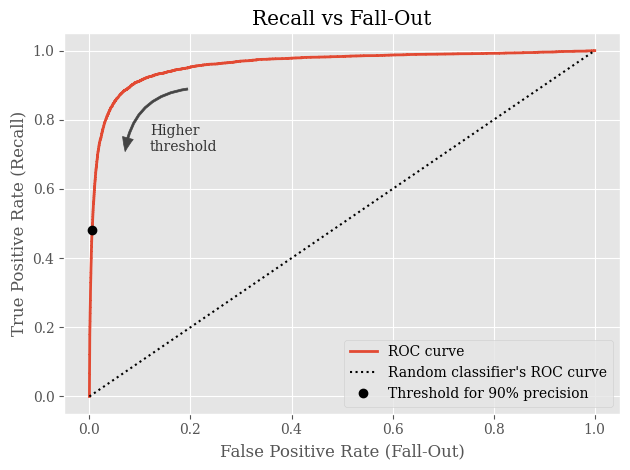

In [106]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_90], fpr[idx_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.title('Recall vs Fall-Out')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc="lower right")
save_fig("roc_curve_plot")

Once again, we are faced with a trade-off. The higher the recall, the more false positives the classifier produces. The dotted line represents the ROC curve of a purely random classifier. A *good* classifier stays as far away from the diagonal dotted line as possible, reaching for the top-left corner.

One way to compare classifiers is to measure the *area under the curve* $\left(AUC\right)$. A perfect classifier will have a ROC $AUC$ equal to $1$, whereas a purely random classifier will have a ROC $AUC$ equal to $0.5$. Scikit-Learn provides a function to compute the ROC's $AUC$.

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve is so similar to the PR curve, it can be ambiguous to outsiders as to why they are significant in evaluating classifier effectiveness in their own ways. **As a general rule of thumb, we should prefer the PR curve for evaluating classifier effectively whenever the positive class is rare or when we are more concerned with false positives rather than false negatives, otherwise the ROC curve is more appropriate.**

As an example, looking to the previous ROC curve and ROC $AUC$ score, we may naively think the classifier performs excellently. This high performing ROC curve is a direct consequence of *few* positive $5$ classifications compared to the amount of $\neg5$ negative classifications. Instead, the PR curve clearly indicates the classifier has room for improvement in that it can reach further toward the upper-right corner.

## The Random Forest Classifier
Let's now train a `RandomForestClassifer` and compare its ROC curve and ROC $AUC$ score to those of the `SGDClassifier`. First, we'll need to get decision function scores for each instance in the training set, but due to the nature of random forest classifiers, decision functions are not appropriate (we can learn about these details later). Instead, Scikit-Learn's `RandomForestClassifer` has a `predict_proba()` method. In general, Scikit-Learn classifiers have a `decision_function()` method, a `predict_proba()` method, or both. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the *probability* that the given instance belongs to the given class (e.g. this instance has a $70\%$ chance of representing a $5$).

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

The `roc_curve()` function expects labels and scores, but instead of scores, we can give it class probabilities. In the context of our binary $5$-predictor, we can use the positive class' probability as the score.

In [33]:
y_scores_forest = y_probas_forest[:, 1] # Grab all rows from the positive class.
fpr_forest, tpr_forest, thresholds_forest  = roc_curve(y_train_5, y_scores_forest)

Now that we are equipped with the Random Forest classifier's fall-out and recall, we can plot its ROC curve against the SGD Classifier's ROC curve to see how they compare.

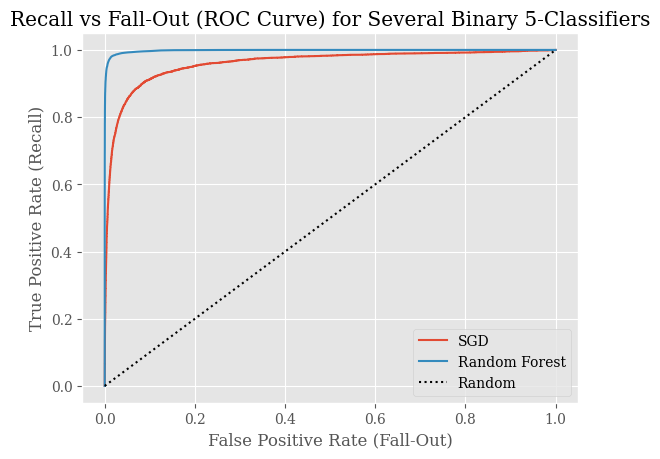

In [35]:
idx_90_forest = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_90], fpr[idx_90]

plt.plot(fpr, tpr, label='SGD')
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k:', label="Random")
plt.title('Recall vs Fall-Out (ROC Curve) for Several Binary 5-Classifiers')
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.legend()
plt.show()

This graph shows that the Random Forest classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC. Let's now calculate all the associated metrics for the Random Forest classifier.

Note that we could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute y_train_pred_forest, but since we *already have* the estimated probabilities (`y_probas_forest`), we can get the same predictions of which instances represent $5$ or $\neg5$ by using a probability threshold of $50\%$ (i.e. if an instance's probability of being a $5$ is greater than or equal to $50\%$, classify it as such).

In [45]:

y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
precision_score_forest = precision_score(y_train_5, y_train_pred_forest)
recall_score_forest = recall_score(y_train_5, y_train_pred_forest)
f1_score_forest = f1_score(y_train_5, y_train_pred_forest)
roc_auc_score_forest = roc_auc_score(y_train_5, y_scores_forest)

PRECISION_REPORT_STR = 'Precision Score'
RECALL_REPORT_STR = 'Recall Score'
F1_REPORT_STR = 'F1 Score'
ROC_AUC_REPORT_STR = 'ROC AUC Score'

report_str_forest =\
f'''
{PRECISION_REPORT_STR:>30}: {precision_score_forest:.4f}
{RECALL_REPORT_STR:>30}: {recall_score_forest:.4f}
{F1_REPORT_STR:>30}: {f1_score_forest:.4f}
{ROC_AUC_REPORT_STR:>30}: {roc_auc_score_forest:.4f}
'''
print(report_str_forest)


               Precision Score: 0.9897
                  Recall Score: 0.8725
                      F1 Score: 0.9275
                 ROC AUC Score: 0.9983

